In [1]:
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
# loading the data into the dataframe
df = pd.read_csv('step6.csv') 
print(df) 

                 Timestamp  PM2.5   PM10    NO2    SO2    CO  Ozone  \
0      2020-01-01 00:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
1      2020-01-01 01:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
2      2020-01-01 02:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
3      2020-01-01 03:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
4      2020-01-01 04:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
...                    ...    ...    ...    ...    ...   ...    ...   
35059  2023-12-31 19:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
35060  2023-12-31 20:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
35061  2023-12-31 21:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
35062  2023-12-31 22:00:00  40.05  68.02  11.86  11.45  1.14   4.55   
35063  2023-12-31 23:00:00  40.05  68.02  11.86  11.45  1.14   4.55   

       Temperature  Relative_humidity  
0             25.3                 95  
1             25.1                 96  
2             25.5         

In [3]:
# viewing info about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          35064 non-null  object 
 1   PM2.5              35064 non-null  float64
 2   PM10               35064 non-null  float64
 3   NO2                35064 non-null  float64
 4   SO2                35064 non-null  float64
 5   CO                 35064 non-null  float64
 6   Ozone              35064 non-null  float64
 7   Temperature        35064 non-null  float64
 8   Relative_humidity  35064 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
#viewing few rows from the top
df.head()

,Timestamp,PM2.5,PM10,NO2,SO2,CO,Ozone,Temperature,Relative_humidity
0,2020-01-01 00:00:00,40.05,68.02,11.86,11.45,1.14,4.55,25.3,95
1,2020-01-01 01:00:00,40.05,68.02,11.86,11.45,1.14,4.55,25.1,96
2,2020-01-01 02:00:00,40.05,68.02,11.86,11.45,1.14,4.55,25.5,93
3,2020-01-01 03:00:00,40.05,68.02,11.86,11.45,1.14,4.55,26.8,85
4,2020-01-01 04:00:00,40.05,68.02,11.86,11.45,1.14,4.55,27.9,78


In [5]:
#number of rows and columns in the dataset
print(df.shape)

(35064, 9)


In [6]:
#statistical information about columns
print(df.describe())

              PM2.5          PM10           NO2           SO2            CO  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      40.052440     68.018187     11.859002     11.448092      1.136315   
std       52.642769     58.428156     12.977451     12.186371      0.560486   
min        0.020000      0.340000      0.010000      0.010000      0.000000   
25%       17.740000     36.000000      3.160000      2.330000      0.870000   
50%       36.270000     64.430000      9.210000     10.790000      1.100000   
75%       43.820000     79.165000     16.552500     15.540000      1.340000   
max      978.170000    999.580000    350.470000    195.720000      8.380000   

              Ozone   Temperature  Relative_humidity  
count  35064.000000  35064.000000       35064.000000  
mean       4.552203     26.557078          84.860284  
std        7.140013      1.896970          10.501644  
min        0.010000     21.000000          30.000000  
25%        1.

In [7]:
#checking how many null values are in each column
df.isnull().sum()

Timestamp            0
PM2.5                0
PM10                 0
NO2                  0
SO2                  0
CO                   0
Ozone                0
Temperature          0
Relative_humidity    0
dtype: int64

Just doing `df.dropna()` drops all the NaN values only for the current execution of the cell. If you do the above `df.isnull().sum()` now, you can see that null values still persists. You can solve this by assigning the obtained output of 
`df.dopna()` to the variable `df` which stores our data (dataframe)

In [8]:
# dropping all the rows with NaN values
df = df.dropna()

In [9]:
#defining training and testing data
x_train = df[:24136]
y_train = x_train['PM2.5']
x_test = df[24136:34043]
y_test = x_test['PM2.5']
print(y_test)

24136    40.05
24137    40.05
24138    40.05
24139    40.05
24140    40.05
         ...  
34038    40.05
34039    43.71
34040    40.05
34041    27.00
34042    40.05
Name: PM2.5, Length: 9907, dtype: float64


There are many pollutants. Let's first try to predict PM2.5 concentration values. Let the years 2016 and 2017 be the testing set. As you can see below, these 2 years account for 21.9% of the data (test set)

In [10]:
df.loc[24865:34043].count() / df.shape[0] * 100

Timestamp            26.177846
PM2.5                26.177846
PM10                 26.177846
NO2                  26.177846
SO2                  26.177846
CO                   26.177846
Ozone                26.177846
Temperature          26.177846
Relative_humidity    26.177846
dtype: float64

In [12]:
#Normalizing training data
train_norm = x_train['PM2.5']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.0409644]
[0.0409644]
[0.0409644]
[0.0409644]
[0.0409644]


Even after normalization and scaing, null values are possible (many people disregard this). Let's check if any null values are present.

In [13]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  1


In [14]:
#removing null values 
train_norm = train_norm[train_norm!=0]

In [15]:
#Normalizing testing data and repeating the same process as done for training data
test_norm = x_test['PM2.5']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.04085555]
[0.04085555]
[0.04085555]
[0.04085555]
[0.04085555]


In [16]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  3


In [17]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [18]:
print(train_norm.shape)
print(test_norm.shape)

(24135,)
(9904,)


Since this is a time series data, we should be predicting the values after looking at a set of values rather than just a single value like we usually do. This takes into account the correlation between the data points and the timestamps. Because the neighbours should be considered for how the values change over time. Let's define a function to do this.

The below function called split_sequence splits the sequence into sets of n values. This n is given as n_steps (step_size). For example, if n=3, we split the sequence in groups of 3. We create 2 empty lists and append the split sequences.

In [19]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

Here the number of features = 1 as we will be predicting a single value. Let's reshape the split sequences into the format of number of rows, number of columns. (shape[0], shape[1]). In the output, we can see that groups of 3 since n_steps = 3 have been obtained.

In [20]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train[i])

[[0.0409644]
 [0.0409644]
 [0.0409644]]
[[0.0409644]
 [0.0409644]
 [0.0409644]]
[[0.0409644]
 [0.0409644]
 [0.0409644]]
[[0.0409644]
 [0.0409644]
 [0.0409644]]
[[0.0409644]
 [0.0409644]
 [0.0409644]]


You can see below that, we predict the value for the first 3 values, then consider that output as one of the 3 values in the next set. For example, we preedict 0.1 first, then we take that 0.1 as input in the second set and so on.

In [21]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

[0.04085555 0.04085555 0.04085555] 0.04085555373793555
[0.04085555 0.04085555 0.04085555] 0.04085555373793555
[0.04085555 0.04085555 0.04085555] 0.04085555373793555
[0.04085555 0.04085555 0.04085555] 0.04085555373793555
[0.04085555 0.04085555 0.04085555] 0.04085555373793555


Let's define our neural network (LSTM: Long Short Term Memory). Let's add 50 nodes in our first layer with a ReLU (Rectified linear unit) activation. Their shape will be step size, number of features. Then we will add, a dense layer with one node for the output.

We can try out different optimizers to see which minimizes loss and maximizes accuracy. Stochastic gradient descent (SGD), Adam, AdaBoost, RMSProp are few of them. lr = learning rate, decay = by how much to decay the learning rate, momentum = how much should the gradient descent be accelerated to dampen oscillations, nesterov = whether to use nesterov momentum. Nesterov has stronger convergence for convex functions. And then we compile using MSE (mean squared loss) as our loss function.

In [22]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Updated parameters: learning_rate instead of lr, and using legacy optimizer
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# If you still want to use decay, you can switch to the legacy optimizer
legacy_sgd = optimizers.legacy.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)

#keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


c:\Users\ELIZABATH GIGI\anaconda3\lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
# fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

Epoch 1/10
755/755 [==============================] - 5s 4ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/10
755/755 [==============================] - 3s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 3/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 5/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 6/10
755/755 [==============================] - 3s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 7/10
755/755 [==============================] - 3s 4ms/step - loss: 0.0021 - accuracy: 0.0000e

In [24]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
actual = model.predict(X_split_test)
for i in range(5):
    print(actual[i])

310/310 [==============================] - 1s 1ms/step
[0.04068379]
[0.04068379]
[0.04068379]
[0.04068379]
[0.04068379]


In [26]:
#mse = mean_squared_error(y_split_test, actual)
#print('MSE: %.5f' % mse)
mse = mean_squared_error(actual,y_split_test)
rmse = np.sqrt(mse)
r2 = r2_score(actual, y_split_test)
 

print("LSTM - Mean Squared Error:", mse)
print("LSTM - Root Mean Squared Error:", rmse)
print("LSTM - R-squared:", r2)

LSTM - Mean Squared Error: 0.0019896363501740147
LSTM - Root Mean Squared Error: 0.04460533992891451
LSTM - R-squared: -0.7845059159440344


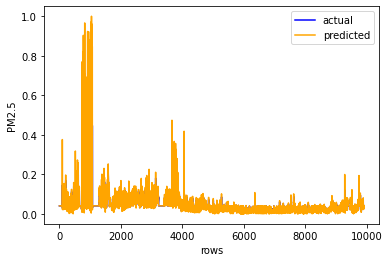

In [27]:
# Plotting the data with different colors
plt.plot(actual, label='actual', color='blue')
plt.plot(y_split_test, label='predicted', color='orange')

# Adding labels and legend
plt.xlabel('rows')
plt.ylabel('PM2.5')
plt.legend()

# Display the plot
plt.show()

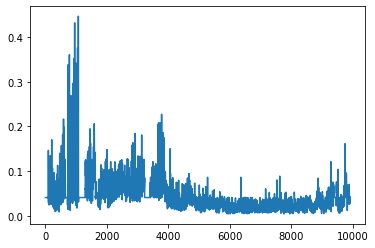

In [28]:
plt.plot(actual)

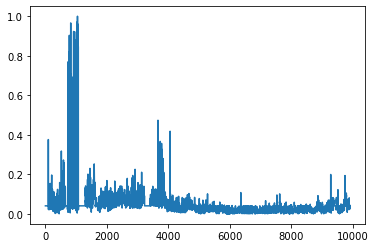

In [29]:
plt.plot(y_split_test)

In [30]:
_, train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00000, Test: 0.00000


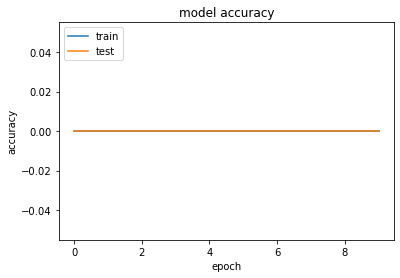

In [31]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

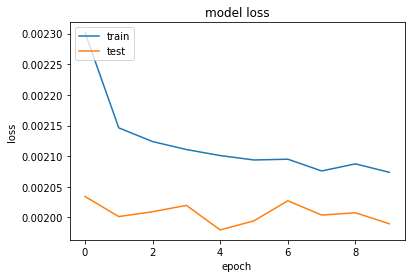

In [32]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Until now, we just ran our model for prediction of a single pollutant. We have 6 pollutants in our dataset and can make predictions for all of them. So, I have made a function which can be used to predict the other pollutants rather than having to write the code again and again. I have commented the function calls. You can fork this kernel to uncomment and predit the other pollutants (Coz it would take up a lot of space and time).

In [33]:
def compute(var):
    train_norm = x_train[var] 
    train_norm_arr = np.asarray(train_norm)
    train_norm = np.reshape(train_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_norm = scaler.fit_transform(train_norm)
    train_norm = train_norm[train_norm != 0]
    
    test_norm = x_test[var]
    test_norm_arr = np.asarray(test_norm)
    test_norm = np.reshape(test_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_norm = scaler.fit_transform(test_norm)
    test_norm = test_norm[test_norm != 0]

    X_split_train, y_split_train = split_sequence(train_norm, n_steps)
    X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

    X_split_test, y_split_test = split_sequence(test_norm, n_steps)
    X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

    hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

    yhat = model.predict(X_split_test)

    mse = mean_squared_error(y_split_test, yhat)
    print(mse)
    
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Epoch 1/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 2/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 3/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 4/10
755/755 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 5/10
755/755 [==============================] - 3s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 6/10
755/755 [==============================] - 3s 4ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 7/10
755/755 [==============================] - 3s 4ms/step - loss: 0.0016 - accuracy: 0.0000e

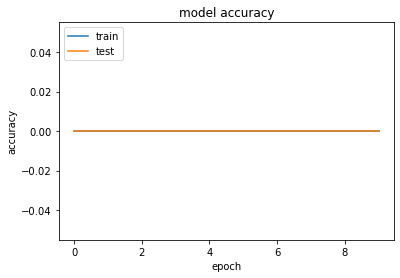

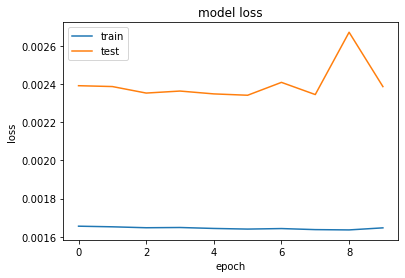

In [34]:
compute('PM10')

Epoch 1/10
751/751 [==============================] - 3s 4ms/step - loss: 4.7972e-04 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/10
751/751 [==============================] - 4s 5ms/step - loss: 4.7481e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 3/10
751/751 [==============================] - 3s 5ms/step - loss: 4.7152e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/10
751/751 [==============================] - 3s 4ms/step - loss: 4.7110e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 5/10
751/751 [==============================] - 4s 5ms/step - loss: 4.6927e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 6/10
751/751 [==============================] - 3s 4ms/step - loss: 4.6986e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 7/10
751/751 [==============================] - 3s 4ms/step - loss: 4.

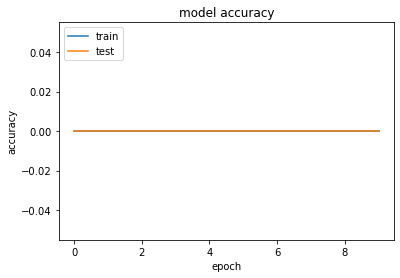

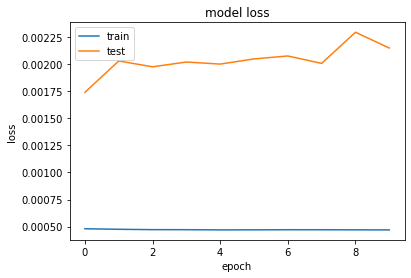

In [35]:
compute('SO2')

Epoch 1/10
755/755 [==============================] - 5s 6ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0036 - val_accuracy: 1.0437e-04
Epoch 2/10
755/755 [==============================] - 4s 6ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0036 - val_accuracy: 1.0437e-04
Epoch 3/10
755/755 [==============================] - 5s 6ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0036 - val_accuracy: 1.0437e-04
Epoch 4/10
755/755 [==============================] - 4s 6ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0037 - val_accuracy: 1.0437e-04
Epoch 5/10
755/755 [==============================] - 4s 5ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0036 - val_accuracy: 1.0437e-04
Epoch 6/10
755/755 [==============================] - 4s 6ms/step - loss: 0.0035 - accuracy: 4.1440e-05 - val_loss: 0.0036 - val_accuracy: 1.0437e-04
Epoch 7/10
755/755 [==============================] - 4s 6ms/step - loss: 0.0035 - accuracy: 4.1440e

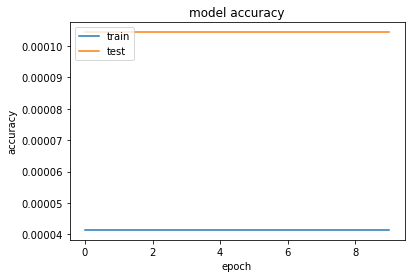

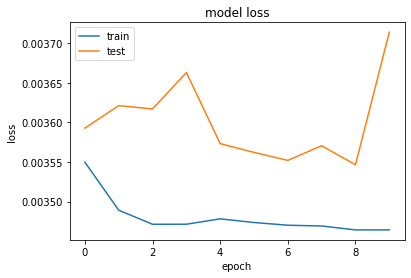

In [ ]:
compute('NO2')

Epoch 1/10
747/747 [==============================] - 5s 6ms/step - loss: 7.6004e-04 - accuracy: 8.3703e-05 - val_loss: 0.0016 - val_accuracy: 1.0414e-04
Epoch 2/10
747/747 [==============================] - 4s 6ms/step - loss: 7.3622e-04 - accuracy: 8.3703e-05 - val_loss: 0.0017 - val_accuracy: 1.0414e-04
Epoch 3/10
747/747 [==============================] - 4s 6ms/step - loss: 7.2974e-04 - accuracy: 8.3703e-05 - val_loss: 0.0016 - val_accuracy: 1.0414e-04
Epoch 4/10
747/747 [==============================] - 4s 6ms/step - loss: 7.2818e-04 - accuracy: 8.3703e-05 - val_loss: 0.0017 - val_accuracy: 1.0414e-04
Epoch 5/10
747/747 [==============================] - 5s 6ms/step - loss: 7.1912e-04 - accuracy: 8.3703e-05 - val_loss: 0.0017 - val_accuracy: 1.0414e-04
Epoch 6/10
747/747 [==============================] - 4s 6ms/step - loss: 7.1798e-04 - accuracy: 8.3703e-05 - val_loss: 0.0017 - val_accuracy: 1.0414e-04
Epoch 7/10
747/747 [==============================] - 5s 6ms/step - loss: 7.

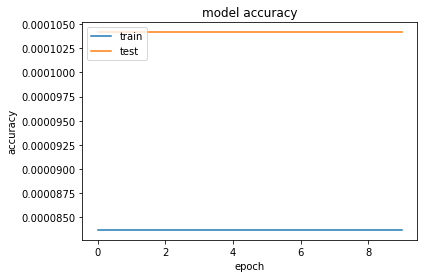

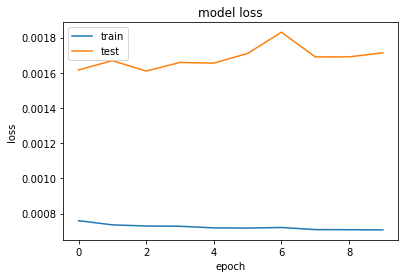

In [ ]:
compute('CO')

Epoch 1/10
754/754 [==============================] - 5s 6ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 1.0107e-04
Epoch 2/10
754/754 [==============================] - 4s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 1.0107e-04
Epoch 3/10
754/754 [==============================] - 5s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 1.0107e-04
Epoch 4/10
754/754 [==============================] - 5s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 1.0107e-04
Epoch 5/10
754/754 [==============================] - 4s 6ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 1.0107e-04
Epoch 6/10
754/754 [==============================] - 4s 6ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 1.0107e-04
Epoch 7/10
754/754 [==============================] - 5s 6ms/step - loss: 0.0014 - accuracy: 0.0000e

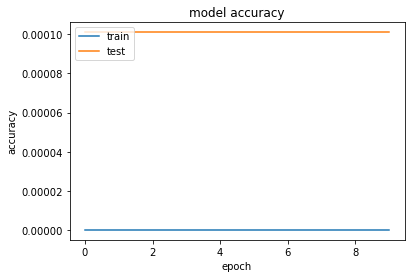

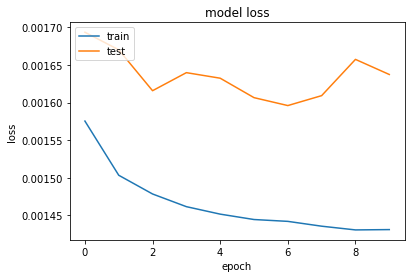

In [ ]:
compute('O3')

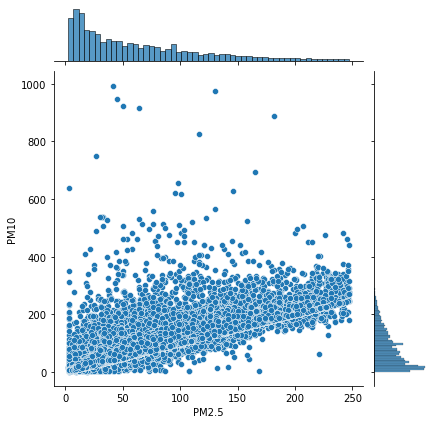

In [ ]:
sns.jointplot(x=df['PM2.5'], y=df['PM10'], data = df)

<AxesSubplot:>

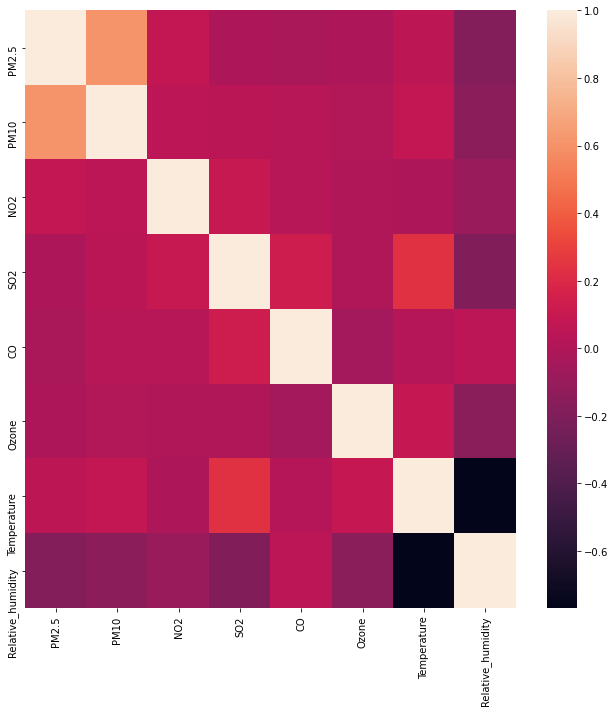

In [36]:
#finding correlation
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrmat)

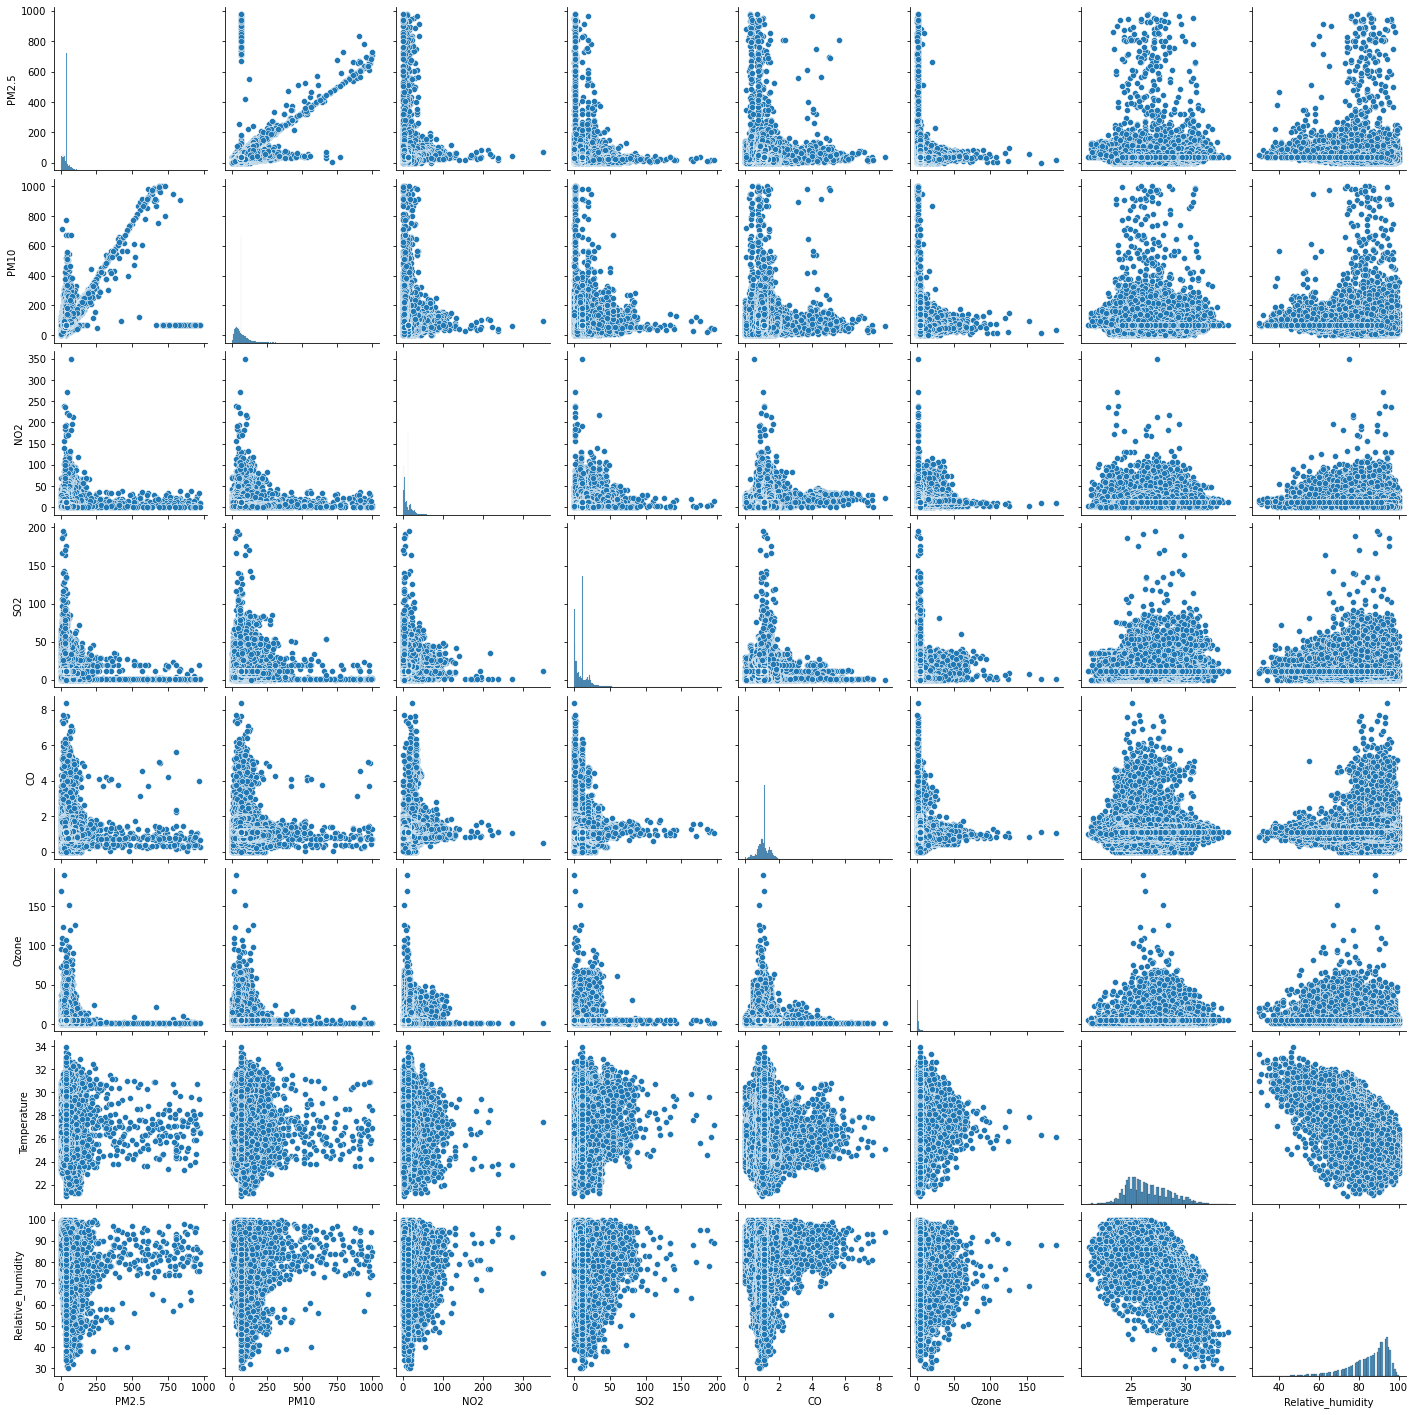

In [37]:
g = sns.pairplot(df)

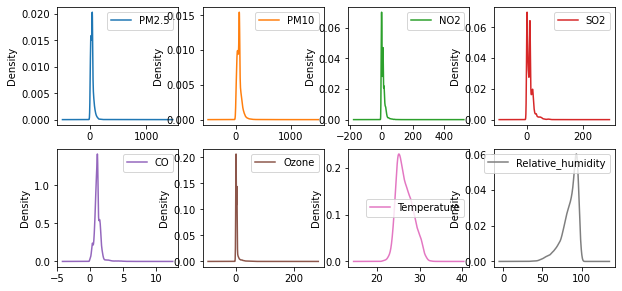

In [38]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(10,10))
plt.show()

<AxesSubplot:xlabel='PM2.5', ylabel='PM10'>

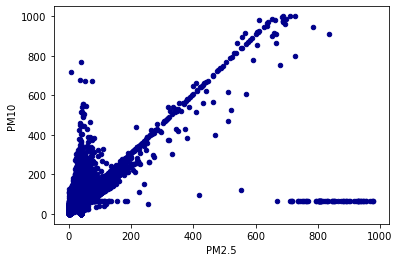

In [39]:
df.plot.scatter(x='PM2.5', y='PM10', c='DarkBlue')

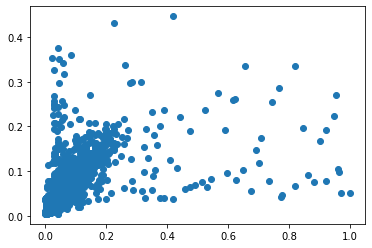

In [40]:
plt.scatter(y_split_test, actual)

<AxesSubplot:xlabel='PM10', ylabel='SO2'>

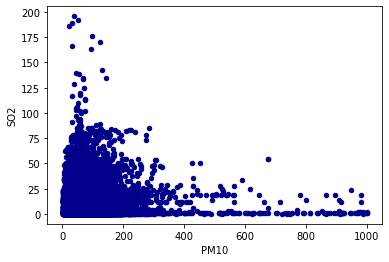

In [41]:
df.plot.scatter(x='PM10', y='SO2', c='DarkBlue')

<AxesSubplot:xlabel='SO2', ylabel='NO2'>

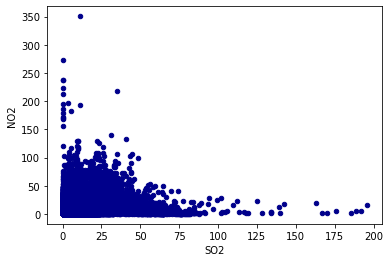

In [42]:
df.plot.scatter(x='SO2', y='NO2', c='DarkBlue')

<AxesSubplot:xlabel='NO2', ylabel='CO'>

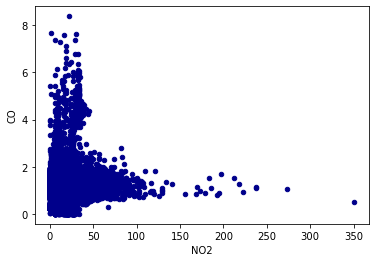

In [43]:
df.plot.scatter(x='NO2', y='CO', c='DarkBlue')

<AxesSubplot:xlabel='CO', ylabel='Ozone'>

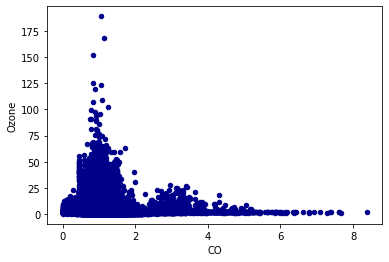

In [45]:
df.plot.scatter(x='CO', y='Ozone', c='DarkBlue')

Heatmap is a very useful visualization tool to know how much each feature is correlated. vmax = max value of the heatmap fmt = number of decimal places upto which the value is shown square = do you want the heatmap to be square shaped linewidth = width of the lines in the heatmap annot = should the boxes be labelled with the value.

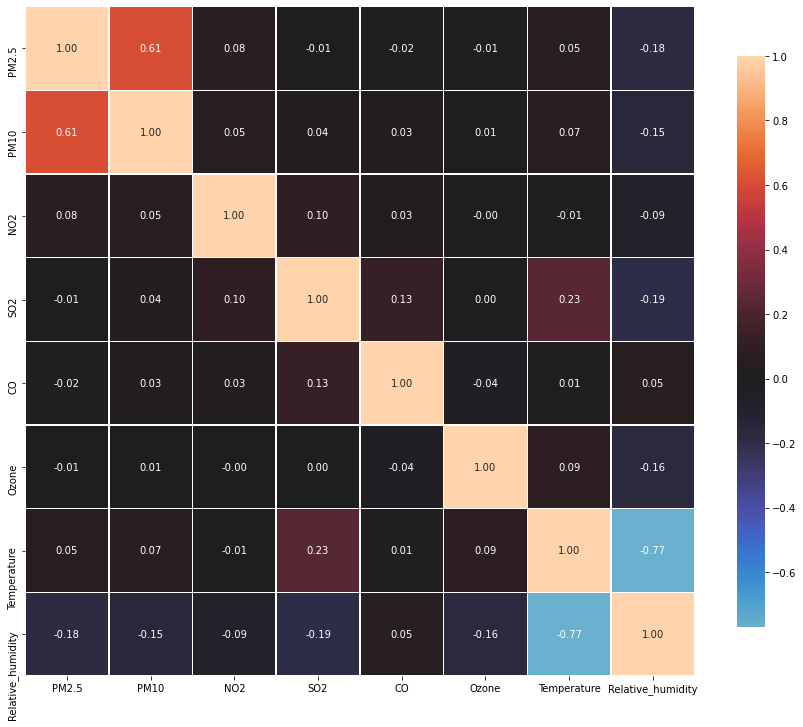

In [46]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show()